In [1]:
from __future__ import print_function
from six.moves import range

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances,cosine_distances
import time
import sys
import warnings
import os
import pickle
import pandas as pd
import PIL
from tqdm import tqdm_notebook
from keras.applications.inception_v3 import preprocess_input
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from miscc.config import cfg, cfg_from_file
from PIL import Image
import datetime
import dateutil.tz
from datasets import TextDataset
from miscc.utils import mkdir_p
from miscc.utils import build_super_images, build_super_images2
from miscc.utils import weights_init, load_params, copy_G_params
from model import G_DCGAN, G_NET
from datasets import prepare_data
from model import RNN_ENCODER, CNN_ENCODER
# from InceptionScore import calculate_inception_score
from miscc.losses import words_loss
from miscc.losses import discriminator_loss, generator_loss, KL_loss
import torchvision.transforms as transforms
from scipy.linalg import sqrtm

/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mshaikh2/anaconda3/envs/pytorch-gp

In [2]:
root = '../data/rep_eval/'
clabel_texts = sorted(os.listdir('../data/rep_eval/'))

In [3]:
# def cosine_similarity(x1, x2, dim=1, eps=1e-8):
#     """Returns cosine similarity between x1 and x2, computed along dim.
#     """
#     w12 = np.sum(x1 * x2, dim)
#     w1 = np.linalg.norm(x1, 2, dim)
#     w2 = np.linalg.norm(x2, 2, dim)
#     return (w12 / np.clip(w1 * w2,a_min=eps,a_max=1e8)).squeeze()

In [4]:
class parse_args():
    cfg_file='../code/cfg/coco_attn2.yml'
    gpu_id=0
    data_dir='../data/coco/'
    manualSeed=1
args = parse_args()

In [5]:
def w2i(w=''):
    return [i for i, val in enumerate(np.array(clabel_texts)==w) if val]
def id2imgidx(i=0):
    return [i for i, val in enumerate(y_test==i) if val]
def fid(act1,act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [6]:
args = parse_args()
if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)

if args.gpu_id == -1:
    cfg.CUDA = False
else:
    cfg.GPU_ID = args.gpu_id

if args.data_dir != '':
    cfg.DATA_DIR = args.data_dir
    

print('Using config:')
display(cfg)

split_dir, bshuffle = 'train', True
if not cfg.TRAIN.FLAG:
    # bshuffle = False
    split_dir = 'test'

Using config:


{'DATASET_NAME': 'coco',
 'CONFIG_NAME': 'glu-gan2',
 'DATA_DIR': '../data/coco/',
 'GPU_ID': 0,
 'CUDA': True,
 'WORKERS': 4,
 'RNN_TYPE': 'LSTM',
 'B_VALIDATION': False,
 'TREE': {'BRANCH_NUM': 3, 'BASE_SIZE': 64},
 'TRAIN': {'BATCH_SIZE': 14,
  'MAX_EPOCH': 150,
  'SNAPSHOT_INTERVAL': 2,
  'DISCRIMINATOR_LR': 0.0002,
  'GENERATOR_LR': 0.0002,
  'ENCODER_LR': 0.0002,
  'RNN_GRAD_CLIP': 0.25,
  'FLAG': True,
  'NET_E': '../DAMSMencoders/coco/text_encoder240.pth',
  'NET_G': '../output/coco_glu-gan2_2020_10_25_15_48_15/Model/netG_epoch_130.pth',
  'B_NET_D': True,
  'SMOOTH': {'GAMMA1': 4.0, 'GAMMA3': 10.0, 'GAMMA2': 5.0, 'LAMBDA': 50.0}},
 'GAN': {'DF_DIM': 96,
  'GF_DIM': 48,
  'Z_DIM': 100,
  'CONDITION_DIM': 100,
  'R_NUM': 3,
  'B_ATTENTION': True,
  'B_DCGAN': False},
 'TEXT': {'CAPTIONS_PER_IMAGE': 5, 'EMBEDDING_DIM': 256, 'WORDS_NUM': 15}}

In [11]:
cfg.TRAIN.NET_E = '../output/coco_DAMSM_2020_10_02_21_37_37/Model/text_encoder105.pth'

In [12]:
imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM-1))
imsize*76/64

304.0

In [13]:
imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM - 1))
image_transform = transforms.Compose([
    transforms.Scale(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])
dataset = TextDataset(cfg.DATA_DIR, split_dir,
                      base_size=cfg.TREE.BASE_SIZE,
                      transform=image_transform)
assert dataset

Load filenames from: ../data/coco//train/filenames.pickle (82783)
Load filenames from: ../data/coco//test/filenames.pickle (40470)
Load from:  ../data/coco/captions.pickle
../data/coco/train


In [14]:
if cfg.TRAIN.NET_G == '':
    print('Error: the path for generator models is not found!')
else:
    
    # Build and load the generator
    if cfg.GAN.B_DCGAN:
        netG = G_DCGAN()
    else:
        netG = G_NET()
    netG.apply(weights_init)
    netG.cuda()
    netG.eval()
    #
    text_encoder = RNN_ENCODER(dataset.n_words, nhidden=cfg.TEXT.EMBEDDING_DIM)
    state_dict = \
        torch.load(cfg.TRAIN.NET_E, map_location=lambda storage, loc: storage)
    text_encoder.load_state_dict(state_dict)
    print('Load text encoder from:', cfg.TRAIN.NET_E)
    text_encoder = text_encoder.cuda()
    text_encoder.eval()

    image_encoder = CNN_ENCODER(cfg.TEXT.EMBEDDING_DIM)
    img_encoder_path = cfg.TRAIN.NET_E.replace('text_encoder', 'image_encoder')
    state_dict = \
        torch.load(img_encoder_path, map_location=lambda storage, loc: storage)
    image_encoder.load_state_dict(state_dict)
    for p in image_encoder.parameters():
        p.requires_grad = False
    print('Load image encoder from:', img_encoder_path)
    image_encoder.eval()


Load text encoder from: ../output/coco_DAMSM_2020_10_02_21_37_37/Model/text_encoder105.pth
Load pretrained model from  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth
Load image encoder from: ../output/coco_DAMSM_2020_10_02_21_37_37/Model/image_encoder105.pth


In [15]:
clabel_texts

['airplane',
 'apple',
 'backpack',
 'banana',
 'baseball bat',
 'baseball glove',
 'bear',
 'bed',
 'bench',
 'bicycle',
 'bird',
 'boat',
 'book',
 'bottle',
 'bowl',
 'broccoli',
 'bus',
 'cake',
 'car',
 'carrot',
 'cat',
 'cell phone',
 'chair',
 'clock',
 'couch',
 'cow',
 'cup',
 'dining table',
 'dog',
 'donut',
 'elephant',
 'fire hydrant',
 'fork',
 'frisbee',
 'giraffe',
 'hair drier',
 'handbag',
 'horse',
 'hot dog',
 'keyboard',
 'kite',
 'knife',
 'laptop',
 'microwave',
 'motorcycle',
 'mouse',
 'orange',
 'oven',
 'parking meter',
 'person',
 'pizza',
 'potted plant',
 'refrigerator',
 'remote',
 'sandwich',
 'scissors',
 'sheep',
 'sink',
 'skateboard',
 'skis',
 'snowboard',
 'spoon',
 'sports ball',
 'stop sign',
 'suitcase',
 'surfboard',
 'teddy bear',
 'television',
 'tennis racket',
 'tie',
 'toaster',
 'toilet',
 'toothbrush',
 'traffic light',
 'train',
 'truck',
 'umbrella',
 'vase',
 'wine glass',
 'zebra']

In [16]:
idx = 2
clabel_texts[idx]


'backpack'

In [17]:
img_folder  = os.path.join(root,'stop sign')
img_list = os.listdir(img_folder)

In [18]:
# selected_id = w2i('aquarium_fish')[0]
# ids = id2imgidx(selected_id)

In [19]:
# imgs = []
# for im in img_list:
#     imgs.append(np.asarray(Image.open(os.path.join(img_folder,im)).convert('RGB').resize((299,299),PIL.Image.ANTIALIAS),dtype=np.int32))
# imgs = np.array(imgs)

In [20]:
# imgs.min(),imgs.max()

In [21]:


# im1 = np.arange(100).reshape((10, 10))
# im2 = im1.T
# im3 = np.flipud(im1)
# im4 = np.fliplr(im2)

# fig = plt.figure(figsize=(6., 6.))
# grid = ImageGrid(fig, 111,  # similar to subplot(111)
#                  nrows_ncols=(4, 4),  # creates 2x2 grid of axes
#                  axes_pad=0.05,  # pad between axes in inch.
#          )

# for ax, im in zip(grid,imgs[:16]):
#     # Iterating over the grid returns the Axes.
#     ax.imshow(im)

# plt.show()
# print(clabel_texts[idx])

In [22]:
# imgs = preprocess_input(x_test[ids])

In [23]:
# imgs.min(),imgs.max()

In [24]:
# print(imgs.shape)
# i = np.rollaxis(imgs,axis=3,start=1)
# i = np.asarray(i,dtype=np.float32)
# print(i.shape)

In [25]:
# img_inp = torch.tensor(i)

In [26]:
# r_emb, i_emb = image_encoder(img_inp)

In [27]:
# r_emb.shape,i_emb.shape

In [28]:
# i_emb = np.asarray(i_emb.detach().cpu())


In [29]:
# selected_id = w2i('bus')[0]
# print(selected_id)
# print(clabel_texts[selected_id])
# t_inp = [dataset.wordtoix[x] for x in [clabel_texts[selected_id]]]
# text_inp = torch.tensor(np.array([t_inp])).cuda()
# print(text_inp)

In [30]:
# w_emb,s_emb = text_encoder(text_inp)

In [31]:
# w_emb.shape, s_emb.shape

In [32]:
# s_emb = np.asarray(s_emb.detach().cpu())
# 

In [33]:
# s_emb.shape,i_emb.shape

In [88]:
# [x for x in zip(emb,w_emb[0])]

In [34]:
# sims = []
# for emb in i_emb:
#     sims.append(cosine_similarity([emb],s_emb))
# # sims

In [35]:
# fid(s_emb,np.array(i_emb))

In [36]:
# df = pd.DataFrame()
# df['sims'] = [float(x) for x in sims]

In [66]:
# list(sims)
# df.describe()
dataset.captions[:10]

[[1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 4, 11, 10, 12, 13, 10, 14],
 [15, 16, 17, 18, 4, 19, 7, 10, 3],
 [10, 20, 21, 22, 19, 23, 24, 25, 26],
 [10, 4, 5, 11, 10, 27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 11, 10, 37, 38],
 [10, 39, 31, 19, 40, 28, 21, 10, 41, 42],
 [43, 31, 44, 45, 11, 8, 46, 47, 35, 48, 49, 50],
 [51, 43, 52, 53, 31, 33, 19, 7, 54, 21, 55],
 [56, 57, 39, 58, 59, 31, 33, 23, 24, 55]]

In [43]:
# df.describe().T['mean'].values[0]
keys = list(dataset.wordtoix.keys())
text_encoder.eval()

RNN_ENCODER(
  (encoder): Embedding(27297, 300)
  (drop): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(300, 128, batch_first=True, dropout=0.5, bidirectional=True)
)

In [79]:
word_feats = {}

for w in tqdm_notebook(clabel_texts,leave=False):
    if ' ' in w:
        w_ = w.split(' ')
    else:
        w_ = [w]
    if w_[0] in keys:
#         result[word+'_img'][w] = {}
        t_inp = [dataset.wordtoix[x] for x in w_]
        batch_size = 1
        hidden = text_encoder.init_hidden(batch_size)
#         print(hidden)
        cap_lens = torch.tensor([len(t_inp)]).cpu()
#         print(cap_lens)
        text_inp = torch.tensor(np.array([t_inp])).cuda()
#         print(text_inp)
        w_emb,s_emb = text_encoder(text_inp,cap_lens,hidden)
        s_emb = np.asarray(s_emb.detach().cpu())
        word_feats[w] = s_emb

In [81]:
word_feats['airplane'].shape

(1, 256)

# P, R, F

In [99]:

result = {}
img_emb = {}
for word in tqdm_notebook(clabel_texts):
    if ' ' in word:
        word_ = word.split(' ')[1]
    else:
        word_ = word
    if word_ in keys:
        result[word+'_img']={}        
        img_folder  = os.path.join(root,word)
        img_list = os.listdir(img_folder)
        imgs = []
        for im in img_list:
            try:
                imgs.append(np.asarray(Image.open(os.path.join(img_folder,im)).convert('RGB').resize((299,299),PIL.Image.ANTIALIAS),dtype=np.int32))
            except Exception as ex:
                pass
        imgs = np.array(imgs)
        imgs = preprocess_input(imgs)
        i = np.rollaxis(imgs,axis=3,start=1)
        i = np.asarray(i,dtype=np.float32)
        img_inp = torch.tensor(i)
        r_emb, i_emb = image_encoder(img_inp)
        i_emb = np.asarray(i_emb.detach().cpu())  
        img_emb[word] = i_emb

#         for w in tqdm_notebook(clabel_texts,leave=False):
#             if ' ' in w:
#                 w_ = w.split(' ')
#             else:
#                 w_ = [w]
#             if w_[0] in keys:
#                 result[word+'_img'][w] = {}
#                 t_inp = [dataset.wordtoix[x] for x in w_]
#                 text_inp = torch.tensor(np.array([t_inp])).cuda()
#                 w_emb,s_emb = text_encoder(text_inp)
#                 s_emb = np.asarray(s_emb.detach().cpu())
#                 sims = []
#                 for emb in i_emb:
#                     sims.append(cosine_similarity([emb],s_emb))
#                 df = pd.DataFrame()
#                 df['sims'] = [float(x) for x in sims]
#                 result[word+'_img'][w]['c_sim_mean'] = np.around(df.describe().T['mean'].values[0],4)
#                 result[word+'_img'][w]['c_sim_std'] = np.around(df.describe().T['std'].values[0],4)
#                 result[word+'_img'][w]['fid'] = np.around(fid(s_emb,np.array(i_emb)),4)

In [101]:
with open('../plots/ImageEmbedding/img_emb_rnn.pickle', 'wb') as f:
    pickle.dump(img_emb,f)

In [102]:
all_classes = np.array(list(img_emb.keys()))

In [103]:
len(word_feats.items())

80

In [104]:
# with open('../plots/ImageEmbedding/img_emb.pickle', 'wb') as f:
#     pickle.dump(img_emb,f)

In [105]:
confusion_matrix=np.zeros((len(all_classes),len(all_classes)))
confusion_matrix.shape

(80, 80)

In [106]:
row,col = -1, -1
confusion_matrix=np.zeros((len(all_classes),len(all_classes)))
confusion_matrix.shape
for kt,vt in tqdm_notebook(img_emb.items()):
    true_label = kt
    ies = img_emb[kt]    
    row+=1
    for ie in tqdm_notebook(ies,leave=False): # 100 images
        preds = []
        for k,v in word_feats.items():
            target_class = k
            we = word_feats[k]
#             print(cosine_similarity([ie],we)[0][0])
            preds.append(cosine_similarity([ie],we)[0][0]) # 80 words
        
        pred_class = np.asarray(preds).argmax(-1)
#         print(pred_class)
        confusion_matrix[row][pred_class]+=1
#         break
#     break


In [107]:
confusion_matrix

array([[100.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,  84.,   0., ...,   1.,   1.,   0.],
       [  0.,   0.,   7., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,  80.,   1.,   0.],
       [  0.,   0.,   0., ...,   1.,  91.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,  98.]])

# C-SIM, FID

In [108]:
confusion_matrix[1,:][1],np.sum(confusion_matrix[1,:])-83

(84.0, 17.0)

78.5 0.5


Text(78.625, 0.5, 'True')

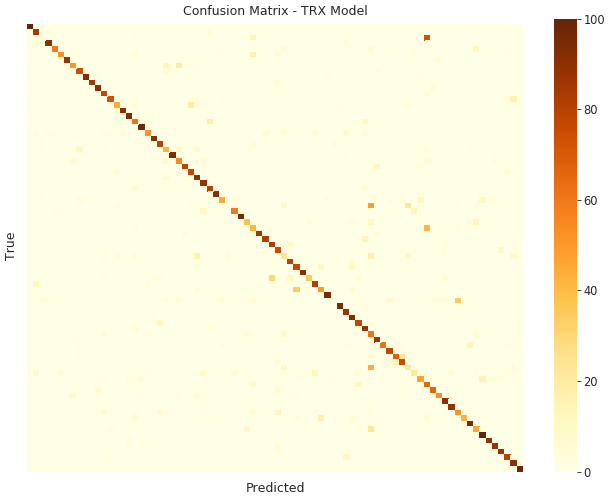

In [109]:
import seaborn as sns
['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
# sns.set(rc={'figure.figsize':(16.0,13)})
sns.set_theme(style='white',font_scale=1.5)

fig, ax = plt.subplots(1, 1, figsize = (16, 12), dpi=50)

# uniform_data = np.random.rand(10, 12)

ax = sns.heatmap(confusion_matrix
                 , annot=False
                 , cmap='YlOrBr')
bottom, top = ax.get_ylim()
print(bottom,top)
ax.set_ylim(bottom + 1.5, top - 1.5)
ax.set_title('Confusion Matrix - TRX Model')
ax.set(xticklabels=[]) 
ax.set(yticklabels=[]) 
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [110]:
df_m = pd.DataFrame(confusion_matrix)

In [111]:
# import matplotlib.pyplot as plt

# index = list(range(80))
# columns = all_classes
# # df = df_m
# Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r
# , BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r
# , Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r
# , PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r
# , PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd
# , PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu
# , RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1
# , Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia
# , Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd
# , YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone
# , bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r
# , coolwarm, coolwarm_r, copper, copper_r, crest, crest_r, cubehelix
# , cubehelix_r, flag, flag_r, flare, flare_r, gist_earth, gist_earth_r
# , gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r
# , gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg
# , gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r
# , hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet
# , jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r
# , ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow
# , rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer
# , summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r
# , terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r
# , viridis, viridis_r, vlag, vlag_r, winter, winter_r

# sns.heatmap(df, annot=False, cmap='YlOrBr',square=True)

In [112]:
def per_class_accuracy(label, confusion_matrix):    
    return confusion_matrix[label,:][label]/ np.sum(confusion_matrix[label,:])

def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [113]:
cm = confusion_matrix
print("label precision recall")
a,p,r = [],[],[]
for label in range(len(all_classes)):
    p.append(precision(label, cm))
    r.append(recall(label, cm))
    a.append(per_class_accuracy(label,cm))
df_metric = pd.DataFrame()
df_metric['classes'] = all_classes
df_metric['precision'] = p
df_metric['recall'] = r
df_metric

label precision recall


classes  precision  recall
0       airplane   0.961538    1.00
1          apple   0.682927    0.84
2       backpack   0.269231    0.07
3         banana   0.841121    0.90
4   baseball bat   0.867647    0.59
..           ...        ...     ...
75         truck   0.861386    0.87
76      umbrella   0.785714    0.88
77          vase   0.714286    0.80
78    wine glass   0.679104    0.91
79         zebra   1.000000    0.98

[80 rows x 3 columns]

In [627]:
print(df_metric)

           classes  precision    recall
0         airplane   0.961538  1.000000
1            apple   0.546053  0.830000
2         backpack   0.347826  0.080000
3           banana   0.946237  0.880000
4     baseball bat   0.885714  0.620000
5   baseball glove   0.907692  0.590000
6             bear   0.936842  0.890000
7              bed   0.682353  0.580000
8            bench   0.559701  0.750000
9          bicycle   0.851852  0.920000
10            bird   0.897959  0.880000
11            boat   0.818182  0.900000
12            book   0.609756  0.750000
13          bottle   0.809524  0.850000
14            bowl   0.533333  0.560000
15        broccoli   0.977778  0.880000
16             bus   0.867925  0.920000
17            cake   0.450450  0.500000
18             car   0.793388  0.960000
19          carrot   0.803922  0.410000
20             cat   0.807339  0.880000
21      cell phone   0.770833  0.740000
22           chair   0.376471  0.320000
23           clock   0.869159  0.930000


In [114]:
print("precision total:", precision_macro_average(cm))
print("recall total:", recall_macro_average(cm))
print("accuracy:", accuracy(cm))
print("error rate:", 1 - accuracy(cm))

precision total: 0.7053129880038841
recall total: 0.7088042929292928
accuracy: 0.7088908340627735
error rate: 0.29110916593722647


In [116]:
keys = list(dataset.wordtoix.keys())
result = {}
for word in tqdm_notebook(clabel_texts):
    if ' ' in word:
        word_ = word.split(' ')[1]
    else:
        word_ = word
    if word_ in keys:
        result[word+'_img']={}        
        
        i_emb = img_emb[word]

        for w in tqdm_notebook(clabel_texts,leave=False):
            if ' ' in w:
                w_ = w.split(' ')
            else:
                w_ = [w]
            if w_[0] in keys:
                result[word+'_img'][w] = {}
                t_inp = [dataset.wordtoix[x] for x in w_]
                batch_size = 1
                hidden = text_encoder.init_hidden(batch_size)
        #         print(hidden)
                cap_lens = torch.tensor([len(t_inp)]).cpu()
        #         print(cap_lens)
                text_inp = torch.tensor(np.array([t_inp])).cuda()
        #         print(text_inp)
                w_emb,s_emb = text_encoder(text_inp,cap_lens,hidden)
                
                
                s_emb = np.asarray(s_emb.detach().cpu())
                sims = []
                for emb in i_emb:
                    sims.append(cosine_similarity([emb],s_emb))
                df = pd.DataFrame()
                df['sims'] = [float(x) for x in sims]
                result[word+'_img'][w]['c_sim_mean'] = np.around(df.describe().T['mean'].values[0],4)
                result[word+'_img'][w]['c_sim_std'] = np.around(df.describe().T['std'].values[0],4)
                result[word+'_img'][w]['fid'] = np.around(fid(s_emb,np.array(i_emb)),4)

In [473]:
def highlight_max(data, color='lightgreen'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns['c_sim_mean'])

In [117]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 1000
dict_of_df = {k: pd.DataFrame(v).T for k,v in result.items()}
df_result = pd.concat(dict_of_df, axis=1)


In [118]:
df_result

airplane_img                       apple_img            \
                 c_sim_mean c_sim_std        fid c_sim_mean c_sim_std   
airplane             0.5425    0.0514  3070.2249    -0.0390    0.0465   
apple                0.0152    0.0391  3243.3850     0.4785    0.1338   
backpack            -0.0693    0.0384  3266.4881    -0.0591    0.0462   
banana               0.0240    0.0502  3230.1732     0.1711    0.0906   
baseball bat         0.0317    0.0461  3217.6020    -0.0068    0.0602   
baseball glove       0.0404    0.0385  3219.5636     0.0372    0.0493   
bear                -0.0464    0.0330  3254.8611    -0.0028    0.0496   
bed                  0.0664    0.0365  3223.9443    -0.0283    0.0596   
bench               -0.0267    0.0439  3254.2048    -0.0442    0.0551   
bicycle             -0.0541    0.0372  3256.4606    -0.0582    0.0596   
bird                 0.0725    0.0528  3220.8759     0.1136    0.0890   
boat                 0.0763    0.0504  3220.8333    -0.0321    0.0437   
book                -0.0393    0.0484  3261.0010     0.0171    0.0640   
bottle              -0.0354    0.0445  3256.6430     0.0086    0.0606   
bowl                 0.0094    0.0459  3249.3679     0.1168    0.0849   
broccoli            -0.0255    0.0566  3240.9802     0.0495    0.0749   
bus                  0.0419    0.0413  3224.8489    -0.0220    0.0486   
cake                -0.0322    0.0484  3255.0670    -0.0390    0.0949   
car                  0.0314    0.0537  3238.0372    -0.0621    0.0520   
carrot               0.0142    0.0466  3243.5250     0.1785    0.0794   
cat                 -0.0252    0.0369  3247.6005    -0.0078    0.0516   
cell phone          -0.0067    0.0461  3238.3200     0.0325    0.0563   
chair               -0.0315    0.0543  3260.0539    -0.0020    0.0571   
clock                0.0111    0.0531  3233.0295    -0.0333    0.0573   
couch                0.0032    0.0341  3248.3736     0.0072    0.0622   
cow                 -0.0061    0.0489  3237.7795    -0.0734    0.0497   
cup                 -0.0584    0.0406  3270.1163     0.0210    0.0784   
dining table        -0.0263    0.0490  3247.5889     0.0154    0.0606   
dog                 -0.0332    0.0396  3250.5812    -0.0711    0.0494   
donut               -0.0427    0.0369  3254.1267     0.2180    0.1152   
elephant            -0.0552    0.0283  3254.1339    -0.0130    0.0434   
fire hydrant        -0.0877    0.0482  3265.2073    -0.0539    0.0829   
fork                 0.0075    0.0528  3247.5368     0.0076    0.0736   
frisbee              0.0127    0.0488  3244.4889     0.0448    0.0577   
giraffe             -0.0226    0.0413  3240.0751    -0.0677    0.0554   
hair drier           0.0454    0.0502  3218.0912     0.0567    0.0763   
handbag             -0.0699    0.0448  3270.7935    -0.0488    0.0536   
horse               -0.0317    0.0522  3250.3556    -0.0550    0.0438   
hot dog              0.0523    0.0332  3218.0013     0.0764    0.0680   
keyboard             0.0628    0.0517  3227.0600     0.0496    0.0718   
kite                 0.0070    0.0819  3237.4754     0.0395    0.0554   
knife                0.0080    0.0666  3251.4224     0.1289    0.0919   
laptop              -0.0359    0.0393  3246.9243    -0.0028    0.0707   
microwave           -0.0350    0.0315  3249.5736     0.0034    0.0668   
motorcycle          -0.0122    0.0416  3243.2821    -0.1028    0.0553   
mouse                0.0788    0.0504  3232.4803     0.1040    0.0784   
orange               0.0095    0.0596  3245.7638     0.2707    0.1123   
oven                -0.0259    0.0461  3244.1896     0.0142    0.0700   
parking meter       -0.0272    0.0511  3237.9202    -0.0322    0.0539   
person              -0.0237    0.0278  3262.9122    -0.0259    0.0432   
pizza               -0.0361    0.0378  3249.6818    -0.0250    0.0689   
potted plant        -0.0128    0.0464  3240.9754     0.0997    0.0797   
refrigerator         0.0236    0.0306  3230.3747     0.0130    0.0677   


In [119]:
subset=[]
for i in list(df_result.keys()):
    if 'c_sim_mean' in i:
        subset.append(i)

In [120]:
df_style = df_result.style.highlight_max(color = 'lightgreen', axis = 0,subset = subset)

In [121]:
df_style

78.5 0.5


Text(78.625, 0.5, 'Tokens')

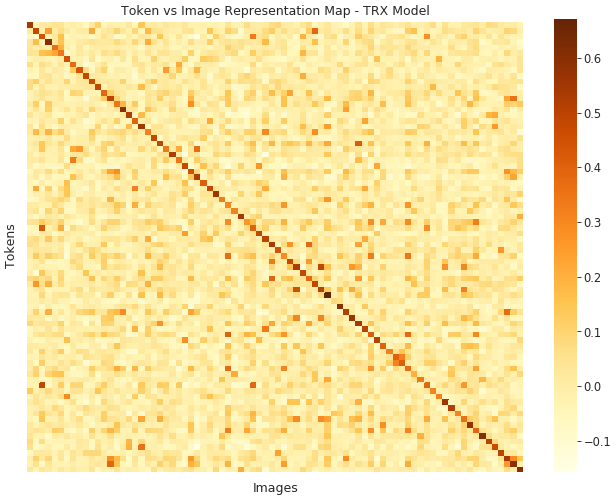

In [122]:

fig, ax = plt.subplots(1, 1, figsize = (16, 12), dpi=50)

ax = sns.heatmap(df_result[subset], annot=False
                 , cmap='YlOrBr')
bottom, top = ax.get_ylim()
print(bottom,top)
ax.set_ylim(bottom + 1.25, top - 1.25)
ax.set_title('Token vs Image Representation Map - TRX Model')
ax.tick_params(left=False, bottom=False)
ax.set(xticklabels=[]) 
ax.set(yticklabels=[]) 
ax.set_xlabel('Images')
ax.set_ylabel('Tokens')

In [ ]:
np.mean(np.diag(df_result[subset]))

In [ ]:
100  7900  tp, fp, tn, fn -- roc curve --  p, r, f
(image feature airplane[1], airplane text , apple ) [argmax]

[100,256] [4,256]

In [87]:
df_style.to_excel('../plots/imagenet_representation_results.xlsx')

In [90]:
np.unique([x[0] for x in df_result.keys()])

array(['airplane_img', 'apple_img', 'backpack_img', 'banana_img',
       'baseball bat_img', 'baseball glove_img', 'bear_img', 'bed_img',
       'bench_img', 'bicycle_img', 'bird_img', 'boat_img', 'book_img',
       'bottle_img', 'bowl_img', 'broccoli_img', 'bus_img', 'cake_img',
       'car_img', 'carrot_img', 'cat_img', 'cell phone_img', 'chair_img',
       'clock_img', 'couch_img', 'cow_img', 'cup_img', 'dining table_img',
       'dog_img', 'donut_img', 'elephant_img', 'fire hydrant_img',
       'fork_img', 'frisbee_img', 'giraffe_img', 'hair drier_img',
       'handbag_img', 'horse_img', 'hot dog_img', 'keyboard_img',
       'kite_img', 'knife_img', 'laptop_img', 'microwave_img',
       'motorcycle_img', 'mouse_img', 'orange_img', 'oven_img',
       'parking meter_img', 'person_img', 'pizza_img', 'potted plant_img',
       'refrigerator_img', 'remote_img', 'sandwich_img', 'scissors_img',
       'sheep_img', 'sink_img', 'skateboard_img', 'skis_img',
       'snowboard_img', 'spoon_im

In [194]:
# key = 'spoon_img'
# key = 'fork_img'
key = 'person_img'
# key = 'backpack_img'
# key = 'stop sign_img'

In [195]:
from scipy.special import softmax

In [196]:
df_result[key]['c_sim_mean'].values+1

array([0.9012, 0.9198, 1.1116, 0.9101, 0.979 , 1.054 , 1.0008, 0.9208,
       0.9525, 0.9697, 1.0147, 0.9619, 0.9497, 1.0325, 0.9081, 0.9541,
       0.9292, 0.9015, 0.9392, 0.9221, 0.9573, 0.9604, 0.9499, 0.9836,
       0.9453, 1.0107, 0.965 , 0.8748, 0.9227, 0.9296, 0.98  , 1.0137,
       0.9513, 0.9048, 1.0001, 1.0811, 1.122 , 0.9577, 0.9551, 0.957 ,
       0.9029, 0.9376, 0.936 , 0.9142, 0.9704, 0.8779, 0.9724, 0.9604,
       1.0039, 1.1677, 0.8811, 0.9387, 0.9805, 0.9604, 0.9472, 0.9447,
       0.9468, 0.8773, 1.0351, 0.9136, 0.9771, 0.9027, 0.9451, 0.9584,
       0.9782, 0.9446, 0.9511, 0.9231, 0.9418, 1.169 , 0.9269, 0.9271,
       0.9146, 0.9638, 0.9274, 0.9886, 1.0022, 1.0065, 0.9421, 0.9555])

In [197]:
df_result[key]['c_sim_mean'] = softmax(df_result[key]['c_sim_mean'].values+1)

In [198]:
colors = []
sim_list = df_result[key]['c_sim_mean']
max_val = sim_list.max()
for sim in sim_list:
    if max_val == sim:
        colors.append('lightgreen')
    else:
        colors.append('lightblue')

In [199]:
df_result[key]

c_sim_mean  c_sim_std       fid
airplane          0.011741     0.0751  711.2093
apple             0.011962     0.0951  681.6605
backpack          0.014491     0.1301  564.4334
banana            0.011846     0.0949  675.0417
baseball bat      0.012691     0.1015  638.1150
baseball glove    0.013680     0.1172  604.3246
bear              0.012971     0.1030  623.2722
bed               0.011974     0.0947  688.6094
bench             0.012359     0.1185  656.1677
bicycle           0.012574     0.1024  648.1066
bird              0.013153     0.0892  636.7551
boat              0.012476     0.0863  656.8726
book              0.012325     0.0967  663.0582
bottle            0.013389     0.0856  616.6562
bowl              0.011823     0.0993  688.9242
broccoli          0.012379     0.0784  670.6828
bus               0.012075     0.0900  680.6027
cake              0.011745     0.1078  681.3364
car               0.012196     0.0951  675.4820
carrot            0.011989     0.0966  663.5412
cat               0.012419     0.0910  669.9149
cell phone        0.012457     0.0820  682.7859
chair             0.012327     0.1429  658.8507
clock             0.012750     0.0731  651.4812
couch             0.012271     0.1135  661.3529
cow               0.013100     0.0954  614.5906
cup               0.012515     0.0868  647.3404
dining table      0.011435     0.0994  713.0539
dog               0.011997     0.0893  688.0072
donut             0.012080     0.0792  662.2718
elephant          0.012704     0.0951  652.3407
fire hydrant      0.013139     0.1267  602.5679
fork              0.012345     0.1006  660.2160
frisbee           0.011784     0.1113  676.5705
giraffe           0.012962     0.0674  619.0119
hair drier        0.014056     0.1695  552.1257
handbag           0.014642     0.1240  552.4574
horse             0.012424     0.1037  653.2705
hot dog           0.012392     0.0735  605.7017
keyboard          0.012415     0.0893  665.8342
kite              0.011761     0.1092  681.4873
knife             0.012177     0.0897  671.3016
laptop            0.012157     0.1018  666.5726
microwave         0.011895     0.0710  682.5694
motorcycle        0.012583     0.1077  656.5447
mouse             0.011471     0.0863  721.4462
orange            0.012608     0.0973  636.9883
oven              0.012457     0.0773  657.3165
parking meter     0.013011     0.0895  634.9670
person            0.015327     0.1335  559.4065
pizza             0.011508     0.0765  698.9415
potted plant      0.012190     0.0848  658.0701
refrigerator      0.012710     0.0779  644.0537
remote            0.012457     0.0759  677.4252
sandwich          0.012294     0.0742  661.6023
scissors          0.012263     0.0967  658.7859
sheep             0.012289     0.0974  682.6806
sink              0.011464     0.0933  721.1415
skateboard        0.013424     0.1433  617.0347
skis              0.011888     0.0836  689.0917
snowboard         0.012667     0.1107  649.7018
spoon             0.011759     0.0956  683.3382
sports ball       0.012268     0.0982  658.9825
stop sign         0.012433     0.0792  652.5680
suitcase          0.012681     0.1235  634.6034
surfboard         0.012262     0.1144  651.8598
teddy bear        0.012342     0.1153  652.7011
television        0.012001     0.1254  686.3075
tennis racket     0.012228     0.0935  655.8956
tie               0.015347     0.1933  542.6503
toaster           0.012047     0.0864  667.5221
toilet            0.012049     0.0807  685.3171
toothbrush        0.011900     0.1017  676.8660
traffic light     0.012500     0.0741  662.1802
train             0.012053     0.0754  697.6385
truck             0.012814     0.1127  650.0568
umbrella          0.012989     0.0917  626.9969
vase              0.013045     0.0952  631.5894
wine glass        0.012232     0.1072  686.4700
zebra             0.012397     0.0727  667.0195

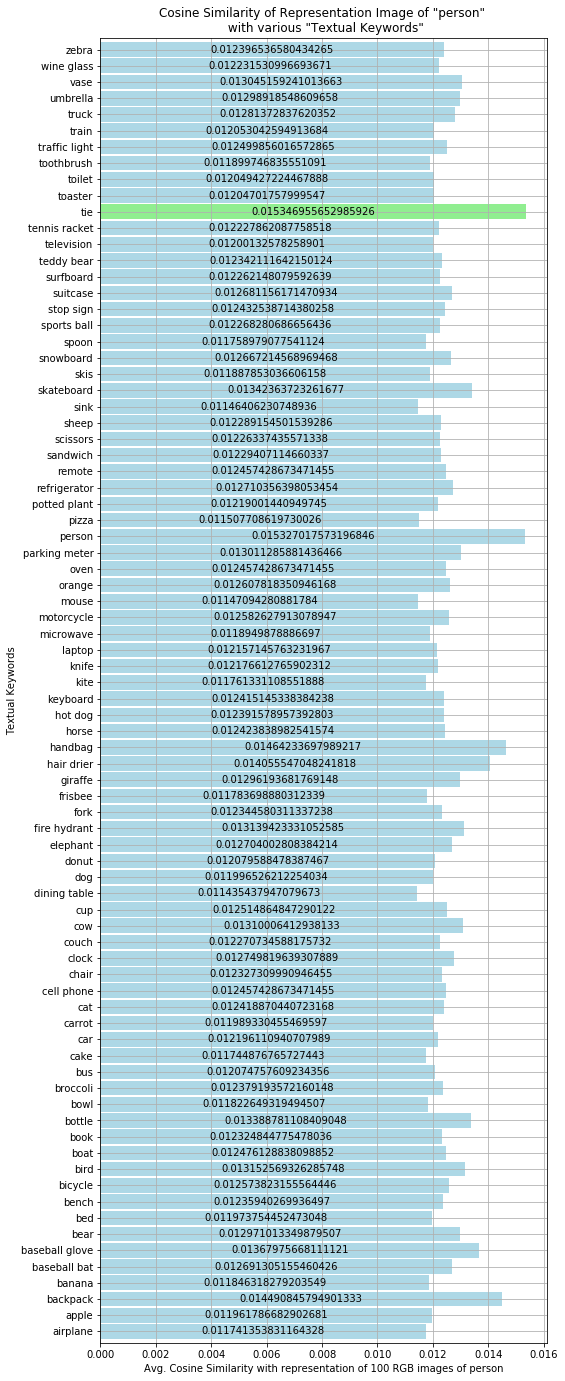

In [200]:
ax = df_result[key]['c_sim_mean'].plot(kind='barh'
                                  , color=colors
                                    ,stacked=True
                             ,figsize=(8,24)
                             ,grid=True,width=0.9
                             ,title='Cosine Similarity of Representation Image of "'+key.split('_')[0]+'" \n with various "Textual Keywords"')

ax.set_xlabel("Avg. Cosine Similarity with representation of 100 RGB images of "+key.split('_')[0])
ax.set_ylabel("Textual Keywords")
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(width), xy=(left+width/2, bottom+height/2), 
                ha='center', va='center')

In [156]:
list(dataset.wordtoix.keys())[:10], len(dataset.wordtoix.keys())

(['<end>',
  'this',
  'metal',
  'park',
  'bench',
  'sits',
  'outside',
  'in',
  'the',
  'sun'],
 27297)

In [151]:
from sentence_transformers import SentenceTransformer

# Load the BERT model. Various models trained on Natural Language Inference (NLI) https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/nli-models.md and 
# Semantic Textual Similarity are available https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/sts-models.md

model = SentenceTransformer('bert-base-nli-mean-tokens')

In [157]:
'this is a kite'.split(' ')

['this', 'is', 'a', 'kite']

In [158]:
[dataset.wordtoix[x] for x in 'this is a kite'.split(' ')]

[1, 115, 10, 333]

In [159]:
embdding_matrix = (27297,768)
'this is a kite'

'this is a kite'

In [160]:
import transformers

In [165]:
bt = transformers.BertTokenizer()
bt.convert_tokens_to_ids(['this'])

Abuzar:
    uniter, attn gan damsm - cub dataset
    convert to bert token ids
    evaluation for one epoch

zhang:
    add code to git hub
    evaluate the current model
    overfitting - fine tuning from start 3 epochs, 6,7 hours
    CTC - ICCV
    
    /MMRL
    git status
    vim .gitignore
    
    -----
    git add .
    git commit -m "sdsdfdf"
    git push
    
Abuzar and Zhang:
    combine the models
    
Paper: 8 pages - 9 pages with ref:
    intro:
        
    related work: Dana
        sub titles 1 image captioning
        , image generation
        , multimodal matching
        , transformer
    methods: arch
        , task 1 - pretraining - damsm - loss
        , task 2 - text2img, img2text
        , multimodal joint training - loss
        , ??cycle??
        , losses - total
        --- images
    experments: 
        dataset: CUBS, COCO, Dana
        settings: lr, gpu
        task 3 - downstream: each down stream explain
        quantitative:
        qualitative:
        evaluation: - damsm, uniter, mmrl
    
    

TypeError: __init__() missing 1 required positional argument: 'vocab_file'

In [311]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower=True)
max_length = 129
caption = "what is your name"
caption_encoded = tokenizer.encode_plus(
            caption, max_length=max_length, padding='max_length', return_attention_mask=True,
            return_token_type_ids=False, truncation=True)
cap_ids, cap_mask = np.array(caption_encoded['input_ids']), (1 - np.array(caption_encoded['attention_mask'])).astype(bool)

In [312]:
caption = "A curvy road"
caption_encoded = tokenizer.encode_plus(
            caption, max_length=max_length, padding='max_length', return_attention_mask=True,
            return_token_type_ids=False, truncation=True)

In [ ]:
# [15,1] -> [emb] -> [15,768] -> encoder -> [15,256], [1,256]

In [318]:
np.asarray(tokenizer.convert_ids_to_tokens(caption_encoded['input_ids']))

array(['[CLS]', 'a', 'cu', '##r', '##vy', 'road', '[SEP]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]

In [204]:
cap_ids, cap_mask

(array([ 101, 2054, 2003, 2115, 2171,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]),
 array([False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, 

In [295]:
tokenizer.convert_tokens_to_ids('what')


2054

In [320]:
state_dict = \
        torch.load(cfg.TRAIN.NET_E, map_location=lambda storage, loc: storage)

In [321]:
state_dict

OrderedDict([('wemb_linear.weight',
              tensor([[-0.0426, -0.0401, -0.0039,  ..., -0.0051,  0.0625, -0.0485],
                      [-0.0868, -0.0236, -0.0143,  ...,  0.0396,  0.0877,  0.1118],
                      [ 0.0669, -0.0490,  0.0286,  ...,  0.0146,  0.0166,  0.0662],
                      ...,
                      [-0.0295,  0.0165, -0.0531,  ...,  0.0866, -0.0162, -0.0089],
                      [ 0.0053, -0.0016, -0.0169,  ..., -0.0109, -0.0315,  0.0011],
                      [ 0.0707, -0.0715,  0.0014,  ..., -0.0307,  0.0197,  0.0005]])),
             ('token_embedding.weight',
              tensor([[ 0.1113, -0.0973,  2.3203,  ..., -0.0828, -0.0947, -0.1041],
                      [-0.1467, -0.4088,  2.4978,  ...,  0.1226,  0.1386,  0.1653],
                      [ 0.3668, -0.1430,  1.5010,  ..., -0.2730, -0.0162, -0.5135],
                      ...,
                      [-0.3013, -0.2359,  2.0405,  ...,  0.0804,  0.2528, -0.1513],
                      [ 0.1

In [209]:
word2idx = {}
for key in dataset.wordtoix.keys():
    word2idx[key]=tokenizer.convert_tokens_to_ids(key)

In [297]:
tokenizer.convert_tokens_to_ids('<end>')

100

In [214]:
np.min(list(word2idx.values())),np.max(list(word2idx.values()))

(100, 29597)

In [232]:
embdding_matrix = np.zeros((29598,768),dtype=np.float32)

In [341]:
token_embedding = np.asarray(state_dict['token_embedding.weight'].detach().cpu())
print(token_embedding.shape)
token_embedding[dataset.wordtoix['curvy']],token_embedding[dataset.wordtoix['<end>']]

(27297, 768)


(array([ 2.14286409e-02, -1.13290691e+00,  6.83190167e-01,  6.84844375e-01,
        -2.37136241e-02, -2.17251331e-01, -1.40694630e+00,  3.82233262e-01,
         4.74072129e-01, -7.75224790e-02,  1.71606272e-01,  1.18519247e-01,
         2.97784090e-01,  2.23363534e-01,  1.51730657e+00,  1.15512751e-01,
        -4.98364061e-01, -3.36997181e-01,  1.49580836e-01,  3.29018421e-02,
        -2.32894421e-01, -7.74358865e-03,  8.90416130e-02, -1.29275775e+00,
        -4.65267092e-01, -1.19210994e+00,  3.25412661e-01, -1.65144771e-01,
        -5.09669125e-01, -6.23028100e-01, -2.74407715e-02, -2.23827511e-01,
         3.10023278e-01, -3.22038859e-01,  5.67301512e-01,  5.77561259e-01,
         4.85880703e-01,  2.11191680e-02,  6.13669399e-03, -1.00957966e+00,
         1.75272870e+00, -1.00469634e-01,  2.48345837e-01, -4.72601205e-02,
        -9.71187174e-01, -5.55629909e-01, -7.38678157e-01,  1.92110658e-01,
        -2.33404711e-01, -1.04205108e+00, -1.26854166e-01, -9.80082035e-01,
        -3.2

In [233]:
for k,v in word2idx.items():
    bert_id = v
    damsm_id = dataset.wordtoix[k]
    embdding_matrix[bert_id] = token_embedding[damsm_id]

In [235]:
embdding_matrix[word2idx['what']]

array([ 3.02927375e-01, -2.87254214e-01,  2.30826926e+00,  2.10747272e-01,
        4.36673313e-01,  1.07008541e+00,  3.21652174e-01,  4.59641099e-01,
       -2.93955356e-01,  1.61868110e-01, -9.23619330e-01,  1.12029694e-01,
        4.49234769e-02,  8.01292896e-01,  9.08490360e-01, -4.26732123e-01,
       -4.02044237e-01, -5.46883941e-01, -4.41669405e-01, -3.53451520e-01,
       -8.43535736e-02,  4.87706393e-01, -1.65242895e-01, -1.17519534e+00,
       -5.31409442e-01, -9.08412635e-01,  1.88279033e-01, -2.15378308e+00,
       -5.89215517e-01, -6.93413243e-02,  3.72062802e-01, -1.54754907e-01,
        7.59108841e-01,  2.43853197e-01, -5.75151324e-01,  2.12018058e-01,
       -8.49808037e-01,  1.91286355e-01,  2.17366368e-01, -2.19830647e-01,
        8.46533597e-01,  9.69425589e-02,  6.41545534e-01,  7.54416466e-01,
       -1.21749029e-01,  2.49009579e-01,  4.36335564e-01,  1.18636243e-01,
       -8.07866037e-01, -1.10000026e+00, -1.38807440e+00, -4.48602766e-01,
        6.98621333e-01,  

In [237]:
token_embedding[dataset.wordtoix['what']]

array([ 3.02927375e-01, -2.87254214e-01,  2.30826926e+00,  2.10747272e-01,
        4.36673313e-01,  1.07008541e+00,  3.21652174e-01,  4.59641099e-01,
       -2.93955356e-01,  1.61868110e-01, -9.23619330e-01,  1.12029694e-01,
        4.49234769e-02,  8.01292896e-01,  9.08490360e-01, -4.26732123e-01,
       -4.02044237e-01, -5.46883941e-01, -4.41669405e-01, -3.53451520e-01,
       -8.43535736e-02,  4.87706393e-01, -1.65242895e-01, -1.17519534e+00,
       -5.31409442e-01, -9.08412635e-01,  1.88279033e-01, -2.15378308e+00,
       -5.89215517e-01, -6.93413243e-02,  3.72062802e-01, -1.54754907e-01,
        7.59108841e-01,  2.43853197e-01, -5.75151324e-01,  2.12018058e-01,
       -8.49808037e-01,  1.91286355e-01,  2.17366368e-01, -2.19830647e-01,
        8.46533597e-01,  9.69425589e-02,  6.41545534e-01,  7.54416466e-01,
       -1.21749029e-01,  2.49009579e-01,  4.36335564e-01,  1.18636243e-01,
       -8.07866037e-01, -1.10000026e+00, -1.38807440e+00, -4.48602766e-01,
        6.98621333e-01,  

In [238]:
state_dict['token_embedding.weight'] = embdding_matrix

In [240]:
torch.save(state_dict,f='../DAMSMencoders/coco/text_encoder240_BERT_ID.pth')

In [242]:
filepath = '../data/coco/captions.pickle'
train_captions, test_captions, ixtoword, wordtoix = pd.read_pickle(filepath)

[[1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 4, 11, 10, 12, 13, 10, 14],
 [15, 16, 17, 18, 4, 19, 7, 10, 3],
 [10, 20, 21, 22, 19, 23, 24, 25, 26],
 [10, 4, 5, 11, 10, 27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 11, 10, 37, 38],
 [10, 39, 31, 19, 40, 28, 21, 10, 41, 42],
 [43, 31, 44, 45, 11, 8, 46, 47, 35, 48, 49, 50],
 [51, 43, 52, 53, 31, 33, 19, 7, 54, 21, 55],
 [56, 57, 39, 58, 59, 31, 33, 23, 24, 55],
 [10, 60, 61, 62, 63, 64, 65, 10, 66, 67, 10, 68],
 [10, 60, 61, 69, 63, 65, 10, 70],
 [8, 60, 61, 62, 63, 71, 65, 8, 72, 34, 73, 74],
 [10, 60, 61, 62, 63, 75, 76, 10, 63, 77],
 [10, 78, 60, 63, 11, 10, 79, 68],
 [10, 80, 81, 82, 7, 10, 83, 84, 85, 86, 34, 87],
 [88, 89, 7, 90, 7, 10, 91, 85],
 [89, 92, 93, 94, 87, 95, 10, 68, 85],
 [10, 96, 21, 89, 95, 10, 97, 98, 95, 8, 99, 85],
 [100, 89, 92, 101, 8, 83, 84, 85, 102, 8, 103],
 [10, 20, 21, 104, 105, 7, 106, 65, 10, 107, 34, 10, 108],
 [56, 104, 19, 11, 10, 106, 34, 10, 108],
 [109, 43, 80, 34, 10, 108, 58, 110, 80, 34, 10, 111, 7, 106],
 

In [281]:
len(train_captions),len(test_captions)

(413915, 202350)

In [270]:
data_dir = '../data/coco/'
filepath = '%s/%s/filenames.pickle' % (data_dir, 'test')
if os.path.isfile(filepath):
    with open(filepath, 'rb') as f:
        filenames = pickle.load(f, encoding='iso-8859-1')
    print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
else:
    filenames = []
filenames

Load filenames from: ../data/coco//test/filenames.pickle (40470)


['COCO_val2014_000000412978',
 'COCO_val2014_000000412975',
 'COCO_val2014_000000243260',
 'COCO_val2014_000000452201',
 'COCO_val2014_000000391588',
 'COCO_val2014_000000391584',
 'COCO_val2014_000000147375',
 'COCO_val2014_000000380609',
 'COCO_val2014_000000318373',
 'COCO_val2014_000000007276',
 'COCO_val2014_000000384114',
 'COCO_val2014_000000007274',
 'COCO_val2014_000000456917',
 'COCO_val2014_000000130419',
 'COCO_val2014_000000007278',
 'COCO_val2014_000000216710',
 'COCO_val2014_000000088412',
 'COCO_val2014_000000488720',
 'COCO_val2014_000000309940',
 'COCO_val2014_000000488723',
 'COCO_val2014_000000424551',
 'COCO_val2014_000000424554',
 'COCO_val2014_000000307243',
 'COCO_val2014_000000136768',
 'COCO_val2014_000000132223',
 'COCO_val2014_000000016451',
 'COCO_val2014_000000506356',
 'COCO_val2014_000000506357',
 'COCO_val2014_000000274331',
 'COCO_val2014_000000268000',
 'COCO_val2014_000000542077',
 'COCO_val2014_000000280083',
 'COCO_val2014_000000542073',
 'COCO_val

In [271]:
from nltk.tokenize import RegexpTokenizer
all_captions = []
for i in tqdm_notebook(range(len(filenames))):
    cap_path = '%s/text/%s.txt' % (data_dir, filenames[i])
    with open(cap_path, "r") as f:
        captions = f.read().split('\n')
        cnt = 0
        for cap in captions:
            if len(cap) == 0:
                continue
            cap = cap.replace("\ufffd\ufffd", " ")
            # picks out sequences of alphanumeric characters as tokens
            # and drops everything else
            tokenizer = RegexpTokenizer(r'\w+')
            tokens = tokenizer.tokenize(cap.lower())
            # print('tokens', tokens)
            if len(tokens) == 0:
                print('cap', cap)
                continue

            tokens_new = []
            for t in tokens:
                t = t.encode('ascii', 'ignore').decode('ascii')
                if len(t) > 0:
                    tokens_new.append(t)
            all_captions.append(tokens_new)
            cnt += 1
            if cnt == 5:# self.embeddings_num:
                break
        if cnt < 5: # self.embeddings_num:
            print('ERROR: the captions for %s less than %d'
                  % (filenames[i], cnt))

cap .
cap .
cap .
cap  
cap  
cap  
cap .
cap  
cap  
cap .
cap .



In [274]:
test_captions_new = []
for t in tqdm_notebook(all_captions):
    rev = []
    for w in t:
        if w in wordtoix:
            rev.append(word2idx[w])
    # rev.append(0)  # do not need '<end>' token
    test_captions_new.append(rev)

In [279]:
len(train_captions_new)

413915

In [280]:
len(test_captions_new)

202350

In [290]:
idx2word = {}
for k,v in word2idx.items():
    if v in idx2word.keys():
        print(v)
    else:
        idx2word[v]=k

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [345]:
for k,v in dataset.wordtoix.items():
    if '<' in k:
        print(k)

<end>


In [291]:
word2idx

{'<end>': 100,
 'this': 2023,
 'metal': 3384,
 'park': 2380,
 'bench': 6847,
 'sits': 7719,
 'outside': 2648,
 'in': 1999,
 'the': 1996,
 'sun': 3103,
 'a': 1037,
 'on': 2006,
 'sidewalk': 11996,
 'underneath': 7650,
 'tree': 3392,
 'curvy': 100,
 'long': 2146,
 'ended': 3092,
 'designer': 5859,
 'sitting': 3564,
 'couple': 3232,
 'of': 1997,
 'benches': 19571,
 'next': 2279,
 'to': 2000,
 'each': 2169,
 'other': 2060,
 'cement': 11297,
 'side': 2217,
 'walk': 3328,
 'railway': 2737,
 'train': 3345,
 'passenger': 4628,
 'cars': 3765,
 'with': 2007,
 'graffiti': 17990,
 'parked': 9083,
 'gravel': 11127,
 'lot': 2843,
 'blue': 2630,
 'along': 2247,
 'green': 2665,
 'forest': 3224,
 'old': 2214,
 'left': 2187,
 'out': 2041,
 'ground': 2598,
 'has': 2038,
 'all': 2035,
 'over': 2058,
 'it': 2009,
 'very': 2200,
 'oddly': 15056,
 'colored': 6910,
 'front': 2392,
 'trees': 3628,
 'two': 2048,
 'abandoned': 4704,
 'and': 1998,
 'white': 2317,
 'red': 2417,
 'double': 3313,
 'decker': 20946,
 

In [ ]:
with open('../data/coco/bert_based_captions.pickle','wb') as f:
    pickle.dump([train_captions_new, test_captions_new,idx2word, wordtoix], f, protocol=2)

In [338]:
model.encode('sizzor')model.encode('neckties')

(array([-7.66443834e-02, -3.72737586e-01,  2.09336758e+00,  3.10124546e-01,
         1.78275332e-01,  6.55618489e-01, -2.97862947e-01,  6.22633338e-01,
         2.44372129e-01, -7.45039731e-02, -6.14759564e-01,  4.59028810e-01,
         5.01017928e-01,  5.16781449e-01,  6.57776475e-01,  3.91100347e-01,
        -9.07786191e-01, -2.55965054e-01,  7.05094635e-01, -8.73058319e-01,
         2.56089985e-01,  6.85098886e-01, -1.81351706e-01, -8.17346752e-01,
        -1.24787927e-01, -3.84812832e-01,  2.35238865e-01, -1.90267909e+00,
        -3.64018261e-01, -2.37520970e-02,  4.22515497e-02, -3.08613688e-01,
         4.05252278e-01, -2.32367426e-01, -3.42244864e-01,  6.21017456e-01,
        -5.69836438e-01,  1.79487661e-01, -4.47285585e-02, -2.40594789e-01,
         1.41281056e+00, -3.41933593e-02,  9.73407149e-01,  1.43391281e-01,
        -9.04291034e-01,  7.93509483e-02, -5.79918995e-02, -1.84095874e-01,
        -2.67092288e-01, -1.26396012e+00, -7.20338881e-01, -5.80517411e-01,
         5.9

In [332]:
w2i_df = pd.DataFrame.from_dict(word2idx,orient='index').reset_index()

In [333]:
w2i_df.columns = ['word','id']

In [335]:

w2i_df = w2i_df.sort_values(by='id',ascending=True)

In [336]:
w2i_df[w2i_df['id']==100]

word   id
0           <end>  100
17137    harbored  100
17136     waiving  100
17135   paraskier  100
17134    beaneath  100
...           ...  ...
10879    neckties  100
10880      sizzor  100
10099        peep  100
11134       roomy  100
11132  partitions  100

[15270 rows x 2 columns]